In [1]:
import torch
import torchaudio as ta
import torchaudio.functional as AF
import math
import logging

import matplotlib.pyplot as plt

## Load a Wav

Samplerate: 32000, Length of wav: 785077


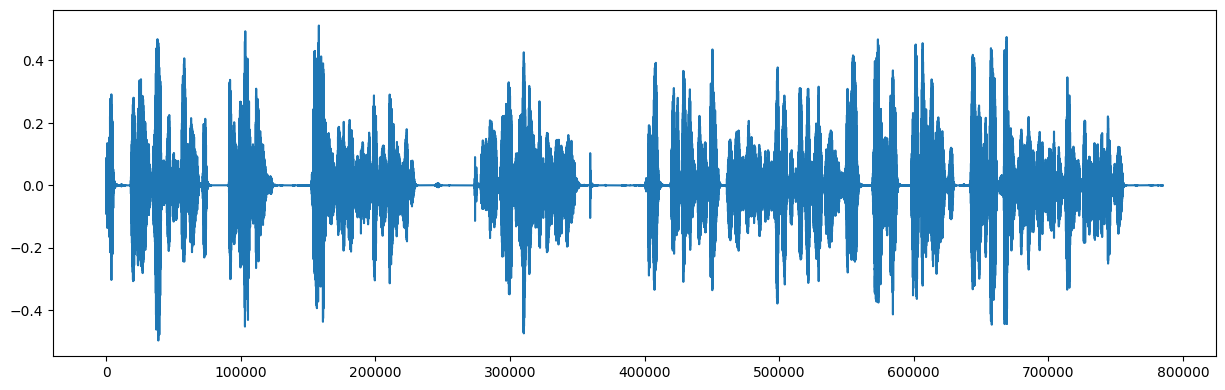

In [54]:
wav_file = '/piece_20_32k.wav'
wav, sr = ta.load(wav_file)
wav = wav[0]
print('Samplerate: {}, Length of wav: {}'.format(sr, len(wav)))
plt.figure(figsize=(15, 4.5))
plt.plot(wav)

## Set parameter

- The coefficient of pre-emphasis: 0.97 
- The length of a frame: 0.02 s
- The length of a hop: 0.01 s
- The length of a speech: 0.5 s
- Low frequency: 300
- High frequency: 3000
- Threshold of energy rate: 0.6

In [4]:
preemph = 0.97
winlen = 0.02
hoplen = 0.01
speechlen = 0.5
lowfreq= 300
highfreq= 3000
thresEnergy = 0.6

## Pre-emphasis

Before we frame a signal, pro-emphasis should be firstly applied to the signal. This step is helpful to focus on formant.

Actually, pre-emphasis is as high-pass filter which is regraded as weighted with later time:

$$s(t)=s(t)-\mu \cdot s(t+1)$$

where $\mu$ is a weight parameter between $(0.9, 1.0)$, in general $0.97$.

For faster, we conduct it using a vecter-style,

$$s[1:] = s[1:]-\mu\cdot s[:-1]$$

Finally, we obtain it as

```python
signal = torch.cat((signal[0:1], signal[1:] - preemph * signal[:-1]))
```

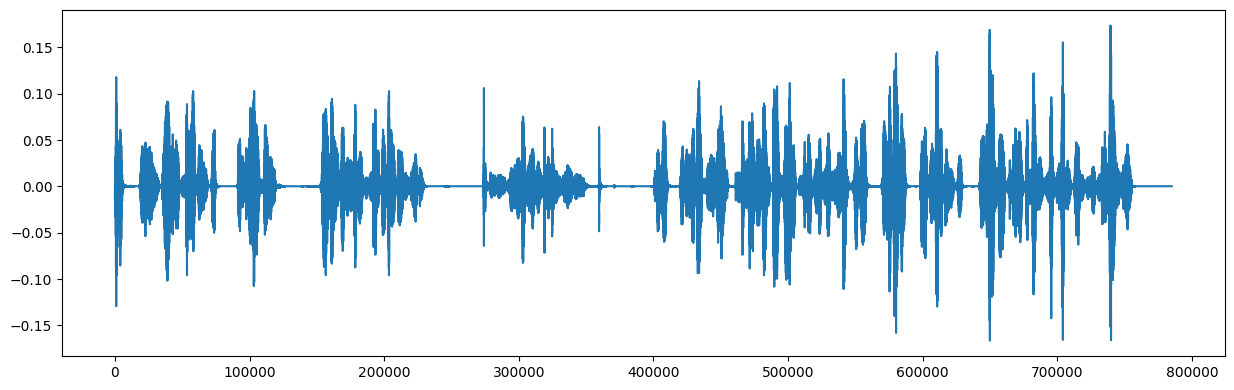

In [55]:
def preemphasis(signal, preemph=0.97):
    """
    Pre-emphasis on the input signal
    :param signal: (time,)
    :param preemph:
    :return: (time,)
    """
    return torch.cat((signal[0:1], signal[1:] - preemph * signal[:-1]))

wav = preemphasis(wav, preemph=preemph)

plt.figure(figsize=(15, 4.5))
plt.plot(wav)

## Frame

After pre-emphasis, we will frame a signal in overlapping frames. The frame denotes a piece signal with the short fixed length, `winlen`.

In general, three quarters of a frame is overlapped by a following frame. So the hop of a frame, `hoplen`, is one quarter of a frame.

Actually, there is a common setting as `winlen = 0.025` and `hoplen = 0.01` which means the length of a frame is 25 ms, and the length of a hop is 10 ms.

As for digital length, the number is related to the sample rate, and we can get the real length as:

$$\text{winlen} = \text{winlen} \times \text{sample rate}$$

$$\text{hoplen} = \text{hoplen} \times \text{sample rate}$$

If you want apply a window function to a frame, it is easy to do it by the element-pair multiplying. 

The length of a frame: 640, the length of a hop: 320


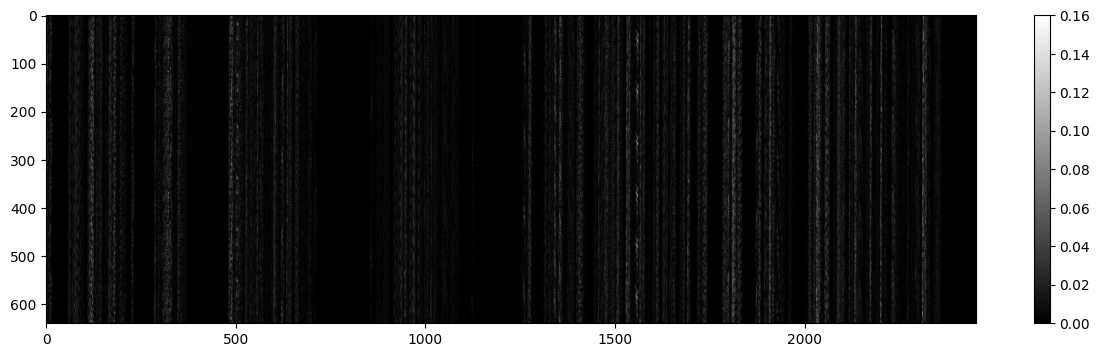

In [56]:
def framesig(signal, framelen, framehop, winfunc=lambda x: torch.ones((x,))):
    """
    Frame a signal into overlapping frames.
    :param signal: (time,)
    :param framelen:
    :param framehop:
    :param winfunc:
    :return: (nframes, framelen)
    """
    slen = len(signal)
    framelen = round(framelen)  # round_half_up(framelen)
    framehop = round(framehop)  # round_half_up(framehop)
    if slen <= framelen:
        nframes = 1
    else:
        nframes = 1 + int(math.ceil((1.0 * slen - framelen) / framehop))

    padlen = int((nframes - 1) * framehop + framelen)

    zeros = torch.zeros((padlen - slen,))
    padsignal = torch.cat((signal, zeros))

    indices = torch.arange(0, framelen).view((1, -1)) \
              + torch.arange(0, nframes * framehop, framehop).view((-1, 1))
    frames = padsignal[indices]
    win = winfunc(framelen).view((1, -1))
    return frames * win

frames = framesig(wav, winlen*sr, hoplen*sr)
print('The length of a frame: {}, the length of a hop: {}'.format(round(winlen*sr), 
                                                                  round(hoplen*sr)))
plt.figure(figsize=(15, 4))
plt.imshow(frames.abs().t(), cmap='gray', aspect='auto', vmin=0, vmax=0.16)
plt.colorbar()

## Energy

Calculate energy of each frame within half frequency of the sample rate:

1. Calculate half frequencies of the sample rate.
2. Calculate energy of each frame by rfft.

<built-in method type of Tensor object at 0x7fd7bc106680>
Shape of freq: torch.Size([320]), Shape of energy: torch.Size([2453, 320])


Text(0.5, 1.0, 'speech frame')

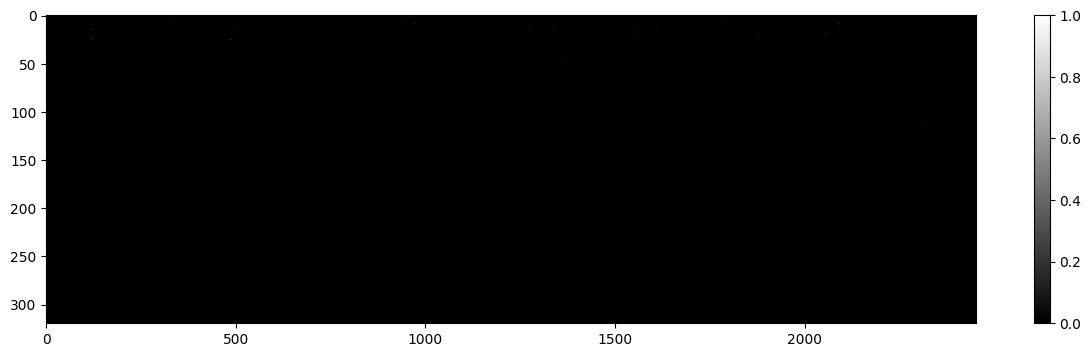

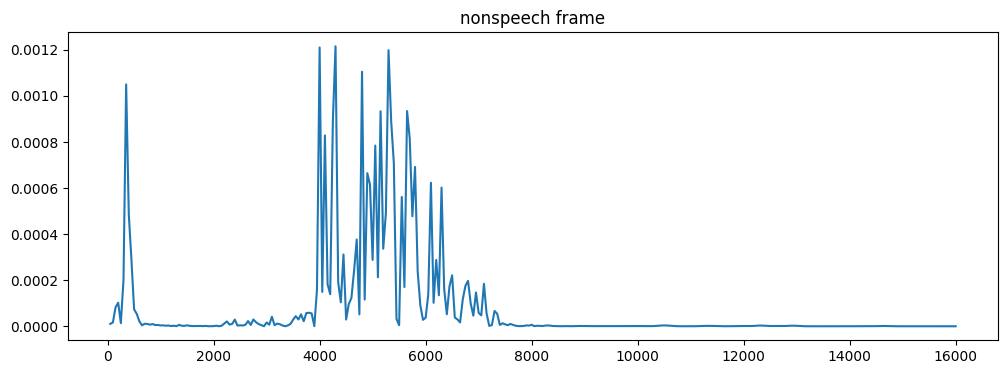

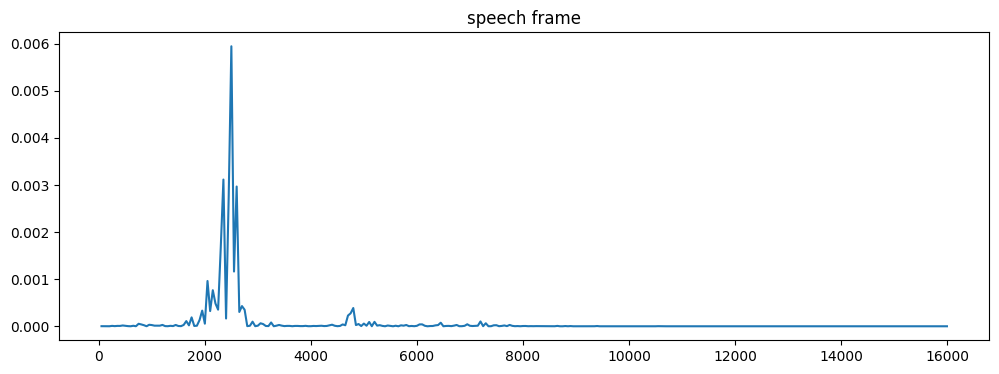

In [66]:
def calculate_frequencies(frames, samplerate):
    """
    Calculate half frequencies of the sample rate.
    :param frame: (nframes, framelen)
    :param samplerate:
    :return: (framelen//2,) or or (framelen//2 - 1,)
    """
    # 半频
    winlen = frames.shape[1]
    t = winlen * 1.0 / samplerate
    if samplerate % 2 == 0:
        return torch.arange(1, winlen // 2 + 1) / t
    else:
        return torch.arange(1, (winlen - 1) // 2 + 1) / t


def calculate_energy(frames):
    """
    Calculate energy of each frame by rfft.
    :param frames: (nframes, framelen)
    :return: (nframes, framelen//2) or (nframes, framelen//2 - 1)
             that equals to half frequencies
    """
    rfft_frames = torch.fft.rfft(frames, dim=-1, norm='ortho')
    mag = torch.abs(rfft_frames)[:,1:]
    energy = mag ** 2
    print(energy.type)
    return energy



def freq_energy(frames, samplerate):
    """
    Calculate a pair of (frequencies, energy) of each frame.
    :param frame: (nframes, framelen)
    :param samplerate:
    :return: freq (framelen//2,) or (framelen//2-1,)
            energy (nframes, framelen//2) or (nframes, framelen//2 - 1) corresponding to freq
    """
    freq = calculate_frequencies(frames, samplerate)
    energy = calculate_energy(frames)
    return freq, energy

freq, energy = freq_energy(frames, sr)
print("Shape of freq: {}, Shape of energy: {}".format(freq.shape, energy.shape))
plt.figure(figsize=(15, 4))
plt.imshow(energy.t(), cmap='gray', aspect='auto', vmin=0., vmax=1)
plt.colorbar()
plt.figure(figsize=(12, 4))
plt.plot(freq, energy[0])
plt.title('nonspeech frame')
plt.figure(figsize=(12, 4))
plt.plot(freq, energy[1000])
plt.title('speech frame')

## Energy Detection by Energy Ratio

Calculate the ratio between energy of speech band and total energy for a frame.

1. Compute the energy between low and high frequencies.
2. Calculate the ratio between full and speech bank of energy.

For faster, all frames are implemented by a vector-style way.

Text(0.5, 1.0, 'speech vs. nonspeech')

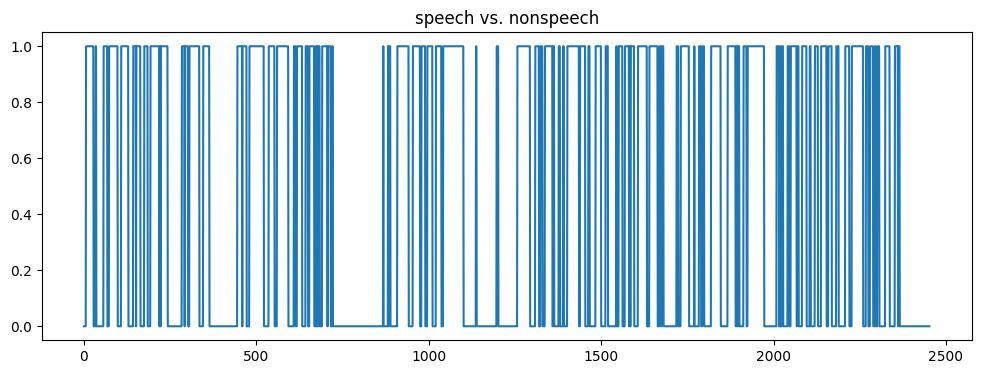

In [67]:
def energy_ratio(freq, energy, thresEnergy, lowfreq, highfreq):
    """
    Calculate the ratio between energy of speech band and total energy for a frame.
    :param freq: (winlen//2)
    :param energy: (nframes, winlen//2)
    :param lowfreq:
    :param highfreq:
    :return: (nframes,)
    """
    voice_energy = torch.sum(energy[:, (freq > lowfreq) & (freq < highfreq)], dim=1)
    full_energy = torch.sum(energy, dim=1)
    full_energy[full_energy == 0] = 2.220446049250313e-16  # 极小正数替换 0
    detection = (torch.div(voice_energy, full_energy) >= thresEnergy).type(torch.float32)
    return detection


detection = energy_ratio(freq, energy, thresEnergy, lowfreq, highfreq)
plt.figure(figsize=(12, 4))
plt.plot(detection)
plt.title('speech vs. nonspeech')

## Smooth Detection

Smooth the detection to the speech length by a median filter.

Here, the length of speech is 0.5. But its usual value is not sure.

Text(0.5, 1.0, 'speech vs. nonspeech')

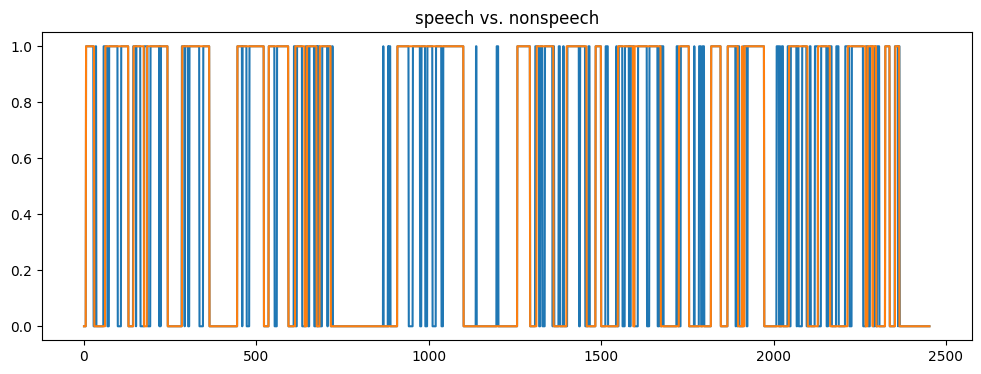

In [68]:
def smooth_detection(detection, winlen, speechlen):
    """
    Apply median filter with length of {speechlen} to smooth detected speech regions
    :param detect: (nframes,)
    :param winlen:
    :param speechlen:
    :return: (nframes,)
    """
    medianwin = max(int(speechlen / winlen), 1)
    if medianwin % 2 == 0:
        medianwin -= 1
    mid = (medianwin - 1) // 2
    y = torch.zeros((len(detection), medianwin), dtype=detection.dtype)
    y[:, mid] = detection
    for i in range(mid):
        j = mid - i
        y[j:, i] = detection[:-j]
        y[:j, i] = detection[0]
        y[:-j, -(i + 1)] = detection[j:]
        y[-j:, -(i + 1)] = detection[-1]
    medianEnergy, _ = torch.median(y.type(torch.float), dim=1)
    return medianEnergy


medianEnergy = smooth_detection(detection, winlen, speechlen)
plt.figure(figsize=(12, 4))
plt.plot(detection)
plt.plot(medianEnergy)
plt.title('speech vs. nonspeech')

## Overall

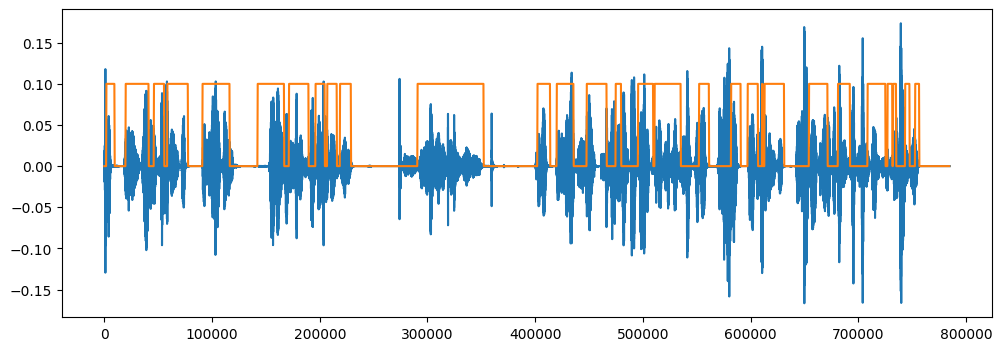

In [69]:
starts = torch.arange(0, frames.shape[0]) * round(hoplen * sr)
plt.figure(figsize=(12, 4))
plt.plot(wav)
plt.plot(starts, medianEnergy*0.1)

# 

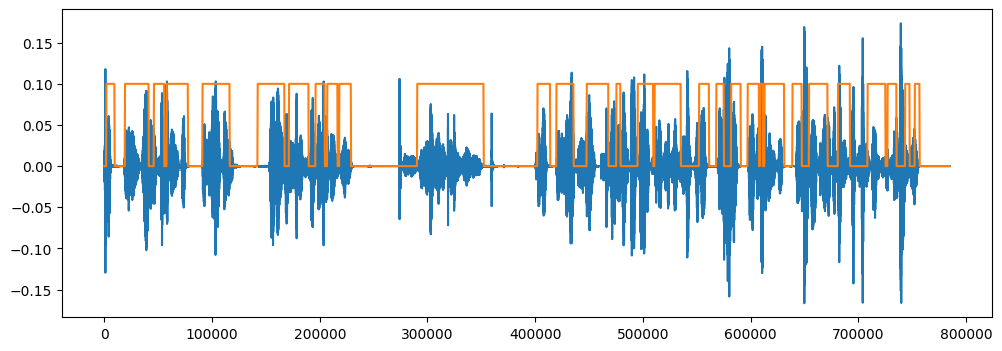

In [61]:
def is_speech(wav, samplerate=16000, winlen=0.02, hoplen=0.01, thresEnergy=0.6, speechlen=0.5,
              lowfreq=300, highfreq=3000, preemph=0.97):
    """
    Use signal energy to detect voice activity in PyTorch's Tensor.
    Detects speech regions based on ratio between speech band energy and total energy.
    Outputs are two tensor with the number of frames where the first output is start frame
        and the second output is to indicate voice activity.
    :param wav: (time,)
    :param samplerate:
    :param winlen:
    :param hoplen:
    :param thresEnergy:
    :param speechlen:
    :param lowfreq:
    :param highfreq:
    :param preemph:
    :return: (nframes,), (nframes,), (time)
    """
    if len(wav) < round(winlen * samplerate):
        return torch.tensor([0]), torch.tensor([0])
    wav = preemphasis(wav, preemph=preemph)
    frames = framesig(wav, winlen * samplerate, hoplen * samplerate)
    freq, energy = freq_energy(frames, samplerate)
    detection = energy_ratio(freq, energy, thresEnergy, lowfreq, highfreq)
    detection = smooth_detection(detection, winlen, speechlen)
    starts = torch.arange(0, frames.shape[0]) * round(hoplen * samplerate)
    return detection, starts, wav

wav_file = '/piece_20_32k.wav'
wav, sr = ta.load(wav_file)
wav = wav[0]
detection, starts, wav = is_speech(wav, samplerate=sr, winlen=0.02, hoplen=0.01,
                              thresEnergy=0.6, speechlen=0.5, lowfreq=300, 
                              highfreq=3000, preemph=0.97)
plt.figure(figsize=(12, 4))
plt.plot(wav)
plt.plot(starts, detection*0.1)